In [1]:
%run /home/bb/src/python/valkyrie/apps/common/run_notebook_import.py

/media/veracrypt1/python/valkyrie/apps/common/run_notebook_import.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import copy
from itertools import product as cartesian_product

from overrides import overrides
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torch.nn import functional as F

from valkyrie.tools import *
from valkyrie.ml import modules
from valkyrie.ml.utils import tensor, HyperParameters
from valkyrie.ml import utils as ml_utils
from valkyrie.nibelungen.data import DataMgr, Df2T2

/media/veracrypt1/python/valkyrie/lib/valkyrie/nibelungen/data.py:192: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [3]:
from valkyrie.ml.data import DataModule

sdate, edate = '2023-01-01', '2023-01-31'
instrs = ['BDM.BTC.USDT.FP']
freq = '1s'
ret_n_s = [120]
root_dir = '/home/bb/data/BDM'
#########################################################
#DataMgr
#########################################################
data_mgr = DataMgr(sdate, edate, freq, root_dir, instrs = instrs, ret_n_s = ret_n_s)
df_res = data_mgr.get(instrs[0]) 
channels = ['bpx_last','apx_last'] + ['bq_last','aq_last','buy_qty_sum', 'sell_qty_sum'] 
n_channels = len(channels)
M = 16
H, W = 16, 16
df2t2 = Df2T2(df_res, M, xcols = channels, ycol = 'mid_last_ret_120_n', yscaler = 1)
dm = DataModule.from_dataset(df2t2, None, 2048)

after dropping na 2678245 -> 2645478


In [4]:
class NetEvaluator:
    def __init__(self, net, dm, device='cuda:0'):
        self.net = net
        self.dm  = dm
        self.device = device
        
    def eval_performance(self):
        self.Y, self.Y_hat = [], []         
        loss, init_loss = 0.0, 0.0        
        dl = dm.get_dataloader(True)
        for i, batch in enumerate(dl):        
            Y = batch[1][:,0].to(self.device)
            with torch.no_grad():                        
                Y_hat = self.net(batch[0].to(self.device))
                loss += (Y_hat.view(-1) - Y.view(-1)).abs().sum()
                init_loss += Y.abs().sum()
            self.Y.append(Y)
            self.Y_hat.append(Y_hat)
            #print(loss)
        score = 1.0 - loss/init_loss
        return score, loss, init_loss
    
class BatchNormAlongW(nn.Module):
    def __init__(self, num_channels, height):
        super(BatchNormAlongW, self).__init__()
        self.num_channels = num_channels
        self.height = height
        self.batch_norm = nn.BatchNorm1d(num_channels * height)

    def forward(self, x):
        N, C, H, W = x.shape
        # Check if the input dimensions match the expected dimensions
        assert C == self.num_channels and H == self.height, "Input dimensions do not match"

        # Permute and reshape tensor to shape (N, H, C*W)
        x = x.view(N, C * H, -1)

        # Apply BatchNorm1d
        x = self.batch_norm(x)

        # Reshape and permute back to original shape (N, C, H, W)
        return x.view(N, C, H, W)

# TEST NET

In [ ]:
class TestNet(modules.Regressor): 
#     def __init__(self, lr, num_channels, height):
#         print("Test Net")
#         super().__init__('l1')
#         self.save_hyperparameters()
#         self.net = nn.Sequential(
#           BatchNormAlongW(num_channels, height),
#           nn.Flatten(),
#           nn.LazyConv2d(256, kernel_size=5, padding=2),
#           nn.LazyConv2d(256, kernel_size=5, padding=2)
#           nn.LazyLinear(1, bias=True)
#         )
        
        
#class AlexNet(modules.Regressor):
    def __init__(self, lr, num_channels, height):
        super().__init__('l1')
        self.save_hyperparameters()
        self.net = nn.Sequential(
            BatchNormAlongW(num_channels, height),
            nn.LazyConv2d(96, kernel_size=3,  padding=1),nn.LeakyReLU(0.1), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.LazyConv2d(256, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            #nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            #nn.LazyConv2d(384, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.LeakyReLU(0.1),nn.Dropout(p=0.5),
            #nn.LazyLinear(4096), nn.LeakyReLU(0.1),nn.Dropout(p=0.5),
            nn.LazyLinear(1))
        self.net.apply(d2l.init_cnn)        

In [9]:
class TestNet(modules.Regressor): 

        
#class AlexNet(modules.Regressor):
    def __init__(self, lr, num_channels, height):
        super().__init__('l1')
        self.save_hyperparameters()
        self.net = nn.Sequential(
            BatchNormAlongW(num_channels, height),
            nn.LazyConv2d(int(96 / 16), kernel_size=3,  padding=1),nn.LeakyReLU(0.1), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(int(384 / 16), kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.LazyConv2d(int(256 / 16), kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(int(4096 / 128)), nn.LeakyReLU(0.1),nn.Dropout(p=0.5),
            nn.LazyLinear(1))
        self.net.apply(d2l.init_cnn)

In [10]:
testNet = TestNet(lr = 1e-4, num_channels = n_channels, height = M)
X = df2t2[0][0]
ml_utils.layer_summary(testNet, X.shape)
ml_utils.parameter_summary(testNet)

input shape torch.Size([6, 16, 16])
name : BatchNormAlongW output shape:	 torch.Size([1, 6, 16, 16])
name : Conv2d output shape:	 torch.Size([1, 6, 16, 16])
name : LeakyReLU output shape:	 torch.Size([1, 6, 16, 16])
name : MaxPool2d output shape:	 torch.Size([1, 6, 7, 7])
name : Conv2d output shape:	 torch.Size([1, 24, 7, 7])
name : LeakyReLU output shape:	 torch.Size([1, 24, 7, 7])
name : Conv2d output shape:	 torch.Size([1, 16, 7, 7])
name : LeakyReLU output shape:	 torch.Size([1, 16, 7, 7])
name : MaxPool2d output shape:	 torch.Size([1, 16, 3, 3])
name : Flatten output shape:	 torch.Size([1, 144])
name : Linear output shape:	 torch.Size([1, 32])
name : LeakyReLU output shape:	 torch.Size([1, 32])
name : Dropout output shape:	 torch.Size([1, 32])
name : Linear output shape:	 torch.Size([1, 1])
total : 9987  param_list : [96, 96, 324, 6, 1296, 24, 3456, 16, 4608, 32, 32, 1]


(9987, [96, 96, 324, 6, 1296, 24, 3456, 16, 4608, 32, 32, 1])

training finished in : 693.280062 secs


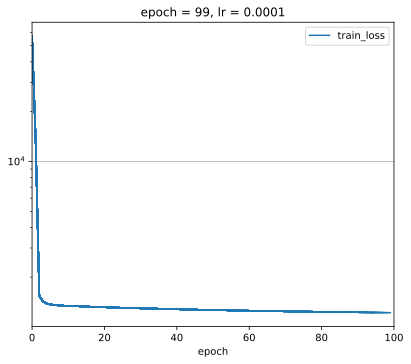

In [11]:
trainer = modules.Trainer(max_epochs=100, num_gpus=1)
with Timer('training'):
    trainer.fit(testNet, dm)

In [12]:
ne = NetEvaluator(testNet, dm)
ne.eval_performance()

(tensor(0.0965, device='cuda:0'),
 tensor(1217.2202, device='cuda:0'),
 tensor(1347.1876, device='cuda:0'))

# GoogleNet

In [ ]:


class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.leaky_relu(self.b1_1(x), 0.1)
        b2 = F.leaky_relu(self.b2_2(F.leaky_relu(self.b2_1(x), 0.1)), 0.1)
        b3 = F.leaky_relu(self.b3_2(F.leaky_relu(self.b3_1(x), 0.1)), 0.1)
        b4 = F.leaky_relu(self.b4_2(self.b4_1(x)), 0.1)
        return torch.cat((b1, b2, b3, b4), dim=1)
        
class GoogleNet(modules.Regressor):
    def b1(self):
        return nn.Sequential(            
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.1), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(        
        nn.LazyConv2d(64, kernel_size=1), nn.LeakyReLU(0.1),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(        
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(
                         Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(
                         Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(
                         Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

@d2l.add_to_class(GoogleNet)
def b0(self):
    return BatchNormAlongW(self.n_channel, self.height)



@d2l.add_to_class(GoogleNet)
def __init__(self, n_channel, height, lr=0.1, num_classes=10):
    #super(GoogleNet, self).__init__()
    self.n_channel = n_channel
    self.height = height
    super(GoogleNet, self).__init__('l1')        
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b0(), self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(1))
    self.net.apply(d2l.init_cnn)

In [ ]:
google_net = GoogleNet(n_channels, H, lr = 0.1)
X = df2t2[0][0]
ml_utils.layer_summary(google_net, X.shape)

In [ ]:
trainer = modules.Trainer(max_epochs=200, num_gpus=1)
with Timer('training'):
    trainer.fit(google_net, dm)

In [ ]:
ne = NetEvaluator(google_net, dm)
ne.eval_performance()

In [ ]:
class MyCNN(nn.Module):
    def __init__(self,num_channels = n_channels, height = 4):
        super(MyCNN, self).__init__()        
        self.bn_along_w = BatchNormAlongW(num_channels, height)  # Example dimensions
        # ... other layers ...

    def forward(self, x):        
        x = self.bn_along_w(x)
        # ... operations for other layers ...
        return x

# Instantiate the model
model = MyCNN()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3  # Number of training epochs

for epoch in range(num_epochs):
    for inputs, labels in dm.get_dataloader(True):
        inputs = inputs
        labels = torch.randn_like(inputs)
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [ ]:
outputs.shape

In [ ]:
inputs.shape

In [ ]:
0.0381 * np.sqrt(1499)

In [ ]:
inputs.mean(axis=0)

In [ ]:
outputs.mean(axis=0)